# Telco Customer Churn: Exploratory Data Analysis (EDA)

**Date:** 2025-11-08    
**Author:** *Luis Renteria Lezano*

## Executive Summary
- **Goal:** Understand the key factors influencing customer churn (whether a customer leaves or stays) to prepare clean, structured data suitable for building baseline and advanced classification models.
- **Source:** This analysis uses the *Telco Customer Churn* dataset published by [IBM Cognos Analytics](https://www.ibm.com/docs/en/cognos-analytics/12.1.x?topic=samples-telco-customer-churn) or in the [IBM Official Repository](https://public.dhe.ibm.com/software/data/sw-library/cognos/mobile/C11/data/?C=M;O=D).
- **Data:** Multiple `.xlsx` files stored in `../data/raw/`, including:
  - `Telco_customer_churn.xlsx`  
  - `Telco_customer_churn_demographics.xlsx`  
  - `Telco_customer_churn_location.xlsx`  
  - `Telco_customer_churn_population.xlsx`  
  - `Telco_customer_churn_services.xlsx`  
  - `Telco_customer_churn_status.xlsx`
- **Target variable:** `Churn Label` (Yes = customer left, No = customer retained)
- **Objective:** Identify and understand relationships between demographics, service usage, contract type, billing, and churn behavior. This EDA will guide feature engineering and model development in later notebooks.

## 0. Reproducibility & Environment Setup
- Pin versions in `../requirements.txt`.
- Keep raw data immutable `../data/raw/`.
- Write cleaned/derived data to `../data/interim/`.
- Export final tables to `../reports/tables/` and figures to `../reports/figures/EDA`.

In [55]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
SEED = 42
np.random.seed(SEED)

# Paths
DATA_RAW = Path("../data/raw")
DATA_INTERIM = Path("../data/interim")
REPORTS_TABLES = Path("../reports/tables")
REPORTS_FIGURES = Path("../reports/figures/EDA")

# Create directories if missing
for folder in [DATA_RAW, DATA_INTERIM, REPORTS_TABLES, REPORTS_FIGURES]:
    folder.mkdir(parents=True, exist_ok=True)

plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.facecolor": "#fafafa",
    "grid.alpha": 0.3
})
sns.set_theme(style='whitegrid', palette='colorblind', context='notebook')
pd.set_option('display.width', 80)       #
pd.set_option('display.max_columns', 10)   #
pd.set_option('display.max_colwidth', 30)  #

print("Folder statuses:")
for d in [DATA_RAW, DATA_INTERIM, REPORTS_TABLES, REPORTS_FIGURES]:
    print(f"\t./{d.as_posix()} - {'Ready' if d.exists() else 'Missing'}")
print("> Environment setup completed.")

Folder statuses:
	./../data/raw - Ready
	./../data/interim - Ready
	./../reports/tables - Ready
	./../reports/figures/EDA - Ready
> Environment setup completed.


## 1. Introduction

This notebook performs an Exploratory Data Analysis (EDA) of the Telco Customer Churn dataset published by IBM Cognos Analytics (2025), in order to understand customer churn behavior, data quality, and the key relationships between demographic, service, and financial variables that influence whether a client leaves or stays.

**Columns available:**

* **Target:**  
`Churn Label` (Yes/No)  
`Churn Value` (1/0)

**General customer and service overview: `Telco_customer_churn.xlsx`**  
`CustomerID`, `Count`, `Country`, `State`, `City`, `Zip Code`, `Lat Long`, `Latitude`, `Longitude`, `Gender`, `Senior Citizen`, `Partner`, `Dependents`, `Tenure Months`, `Phone Service`, `Multiple Lines`, `Internet Service`, `Online Security`, `Online Backup`, `Device Protection`, `Tech Support`, `Streaming TV`, `Streaming Movies`, `Contract`, `Paperless Billing`, `Payment Method`, `Monthly Charges`, `Total Charges`, `Churn Label`, `Churn Value`, `Churn Score`, `CLTV`, `Churn Reason`.

**Demographic profile: `Telco_customer_churn_demographics.xlsx`**  
`Customer ID`, `Count`, `Gender`, `Age`, `Under 30`, `Senior Citizen`, `Married`, `Dependents`, `Number of Dependents`.

**Detailed service usage and billing: `Telco_customer_churn_services.xlsx`**  
`Service ID`, `Customer ID`, `Count`, `Quarter`, `Referred a Friend`, `Number of Referrals`, `Tenure in Months`, `Offer`, `Phone Service`, `Avg Monthly Long Distance Charges`, `Multiple Lines`, `Internet Service`, `Internet Type`, `Avg Monthly GB Download`, `Online Security`, `Online Backup`, `Device Protection Plan`, `Premium Tech Support`, `Streaming TV`, `Streaming Movies`, `Streaming Music`, `Unlimited Data`, `Contract`, `Paperless Billing`, `Payment Method`, `Monthly Charge`, `Total Charges`, `Total Refunds`, `Total Extra Data Charges`, `Total Long Distance Charges`, `Total Revenue`.

**Customer satisfaction and churn outcomes: `Telco_customer_churn_status.xlsx`**  
`Status ID`, `Customer ID`, `Count`, `Quarter`, `Satisfaction Score`, `Customer Status`, `Churn Label`, `Churn Value`, `Churn Score`, `CLTV`, `Churn Category`, `Churn Reason`.

**Geographic and spatial attributes: `Telco_customer_churn_location.xlsx`**  
`Location ID`, `Customer ID`, `Count`, `Country`, `State`, `City`, `Zip Code`, `Lat Long`, `Latitude`, `Longitude`.

**External demographic context (aggregated by ZIP Code): `Telco_customer_churn_population.xlsx`**  
`ID`, `Zip Code`, `Population`.

> This project uses only **`Telco_customer_churn_demographics.xlsx`**, **`Telco_customer_churn_services.xlsx`**, and **`Telco_customer_churn_status.xlsx`**, which contain all key demographic, service, and churn outcome data for modeling.
> 
> The main **`Telco_customer_churn.xlsx`** is excluded because it’s a pre-aggregated dashboard file duplicating information from the others.


**Purpose of this EDA:**

* Understand the structure, completeness, and relationships within all six data sources.
* Evaluate data quality, missing values, and type consistency across datasets.
* Explore demographic and behavioral patterns associated with customer churn.
* Identify key service, contract, and satisfaction features driving churn.
* Prepare a unified, feature-engineered dataset suitable for supervised classification models (e.g., Logistic Regression, RandomForest, Gradient Boosting).

## 2. Data Load, Merge & Overview
Data load, dtypes and basic checks.

In [2]:
df_churn_demographics = pd.read_excel(DATA_RAW / 'Telco_customer_churn_demographics.xlsx')
df_churn_services = pd.read_excel(DATA_RAW / 'Telco_customer_churn_services.xlsx')
df_churn_status = pd.read_excel(DATA_RAW / 'Telco_customer_churn_status.xlsx')

In [3]:
dfs = [df_churn_demographics, df_churn_services, df_churn_status]

# Dropping innecesary and count columns
cols_to_drop = ['Count', 'Quarter', 'ID', 'Service_ID', 'Status_ID']
for df in dfs:
    df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True, errors='ignore')
    
# Column names normalization
for df in dfs:
    df.columns = (df.columns.str.strip().str.replace(" ", "_").str.lower())
    df.rename(columns={"customerid": "customer_id"}, inplace=True)

# Column Merge
df_merged = pd.merge(df_churn_demographics, df_churn_services, on="customer_id", how="outer")  
df_merged = pd.merge(df_merged, df_churn_status, on="customer_id", how="outer")  
df_merged = df_merged.loc[:, ~df_merged.columns.duplicated()]
df = df_merged.copy()
print(f'This DataFrame contanis:\n- {df.shape[0]} rows\n- {df.shape[1]} columns')
df.head(3)

This DataFrame contanis:
- 7043 rows
- 45 columns


,customer_id,gender,age,under_30,senior_citizen,...,churn_value,churn_score,cltv,churn_category,churn_reason
0,0002-ORFBO,Female,37,No,No,...,0,65,2205,NaN,NaN
1,0003-MKNFE,Male,46,No,No,...,0,66,5414,NaN,NaN
2,0004-TLHLJ,Male,50,No,No,...,1,71,4479,Competitor,Competitor had better devices


In [4]:
# Dtypes and quick stats without showing all the 81 features. Use verbose=True to see it.
display(df.info(verbose=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Columns: 45 entries, customer_id to churn_reason
dtypes: float64(6), int64(10), object(29)
memory usage: 2.4+ MB


None

In [5]:
# First 10 numeric features description
df.describe().T.sort_index().head(10)

,count,mean,std,min,25%,50%,75%,max
age,7043.0,46.509726,16.750352,19.00,32.00,46.00,60.000,80.00
avg_monthly_gb_download,7043.0,20.515405,20.418940,0.00,3.00,17.00,27.000,85.00
avg_monthly_long_distance_charges,7043.0,22.958954,15.448113,0.00,9.21,22.89,36.395,49.99
churn_score,7043.0,58.505040,21.170031,5.00,40.00,61.00,75.500,96.00
churn_value,7043.0,0.265370,0.441561,0.00,0.00,0.00,1.000,1.00
cltv,7043.0,4400.295755,1183.057152,2003.00,3469.00,4527.00,5380.500,6500.00
monthly_charge,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.850,118.75
number_of_dependents,7043.0,0.468692,0.962802,0.00,0.00,0.00,0.000,9.00
number_of_referrals,7043.0,1.951867,3.001199,0.00,0.00,0.00,3.000,11.00
satisfaction_score,7043.0,3.244924,1.201657,1.00,3.00,3.00,4.000,5.00


In [6]:
# First 10 categorical features description
df.drop(['customer_id', 'service_id', 'status_id'], axis=1).describe(include=['object']).T.sort_index().head(10)

,count,unique,top,freq
churn_category,1869,5,Competitor,841
churn_label,7043,2,No,5174
churn_reason,1869,20,Competitor had better devices,313
contract,7043,3,Month-to-Month,3610
customer_status,7043,3,Stayed,4720
dependents,7043,2,No,5416
device_protection_plan,7043,2,No,4621
gender,7043,2,Male,3555
internet_service,7043,2,Yes,5517
internet_type,5517,3,Fiber Optic,3035


## 3. Data Quality & Missing Values

>`satisfaction_score`, `churn_score` and `cltv` are leakage-prone features. They are made only for churned customers, making them unsuitable for training or evaluation. Dropping them ensures integrity.

In [7]:
df = df.drop(['churn_reason', 'churn_category', 'customer_status', 'churn_score', 'satisfaction_score', 'cltv'], axis=1).copy()
# All missing values
missing_values = df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)
missing_values.head()

offer            3877
internet_type    1526
dtype: int64

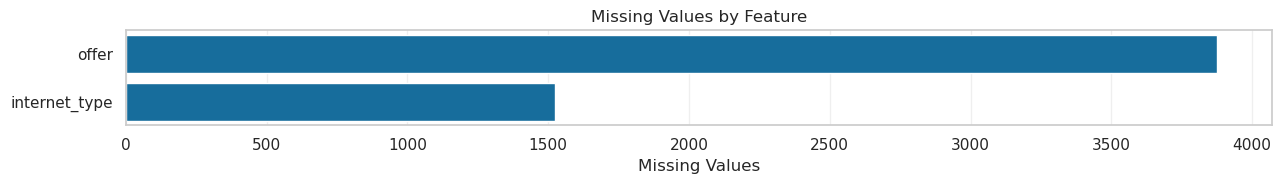

In [8]:
fig, ax = plt.subplots(figsize=(13, 2))
sns.barplot(x=missing_values.values, y=missing_values.index, ax=ax)
ax.set(title='Missing Values by Feature', xlabel='Missing Values', ylabel='')
plt.tight_layout()
plt.savefig(REPORTS_FIGURES / '01_missing_values.png', dpi=150)
plt.show()

## 4. Target Exploration

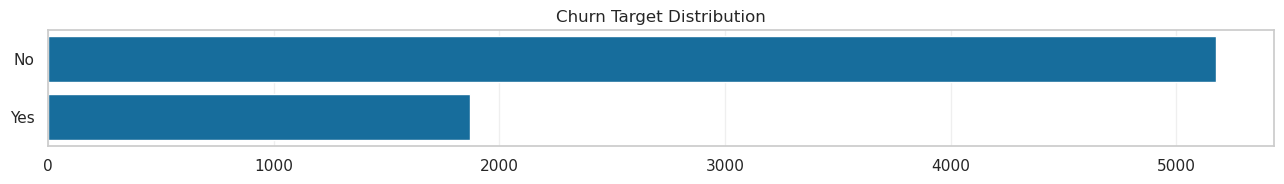

In [9]:
fig, ax = plt.subplots(figsize=(13, 2))
sns.countplot(data=df, y='churn_label')
ax.set(title='Churn Target Distribution', xlabel='', ylabel='')
plt.tight_layout()
plt.savefig(REPORTS_FIGURES / '02_target_distribution.png', dpi=150)
plt.show()

## 5. Univariate Exploration

### 5.1. Numerical Features

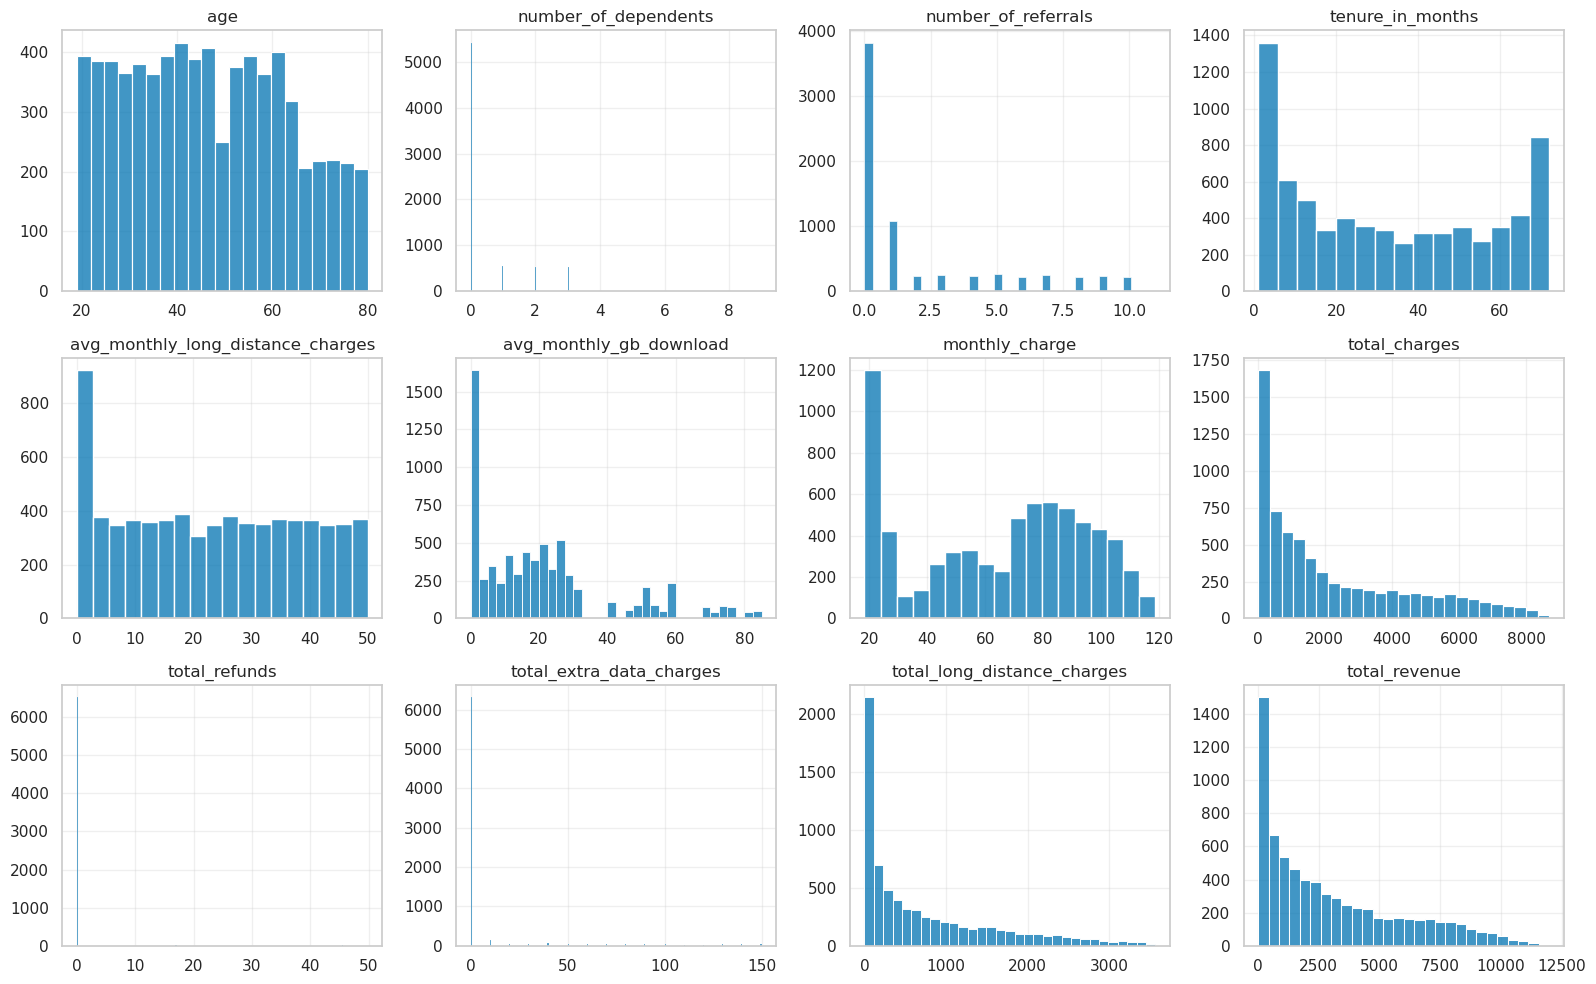

In [10]:
num_cols = df.drop('churn_value', axis=1).select_dtypes(['number', 'float64', 'int64']).columns

c = 0
fig, ax = plt.subplots(3, 4, figsize=(16,10))
for i in range(3):
    for j in range(4):
        if c >= len(num_cols):
            ax[i][j].set_visible(False)
            continue
        sns.histplot(data=df, x=num_cols[c], ax=ax[i][j])
        ax[i][j].set(title=num_cols[c], xlabel='', ylabel='')
        c += 1
    plt.tight_layout()
        
plt.savefig(REPORTS_FIGURES / '03_numeric_feat_distribution.png', dpi=150)
plt.show()

### 5.2. Categorical Features

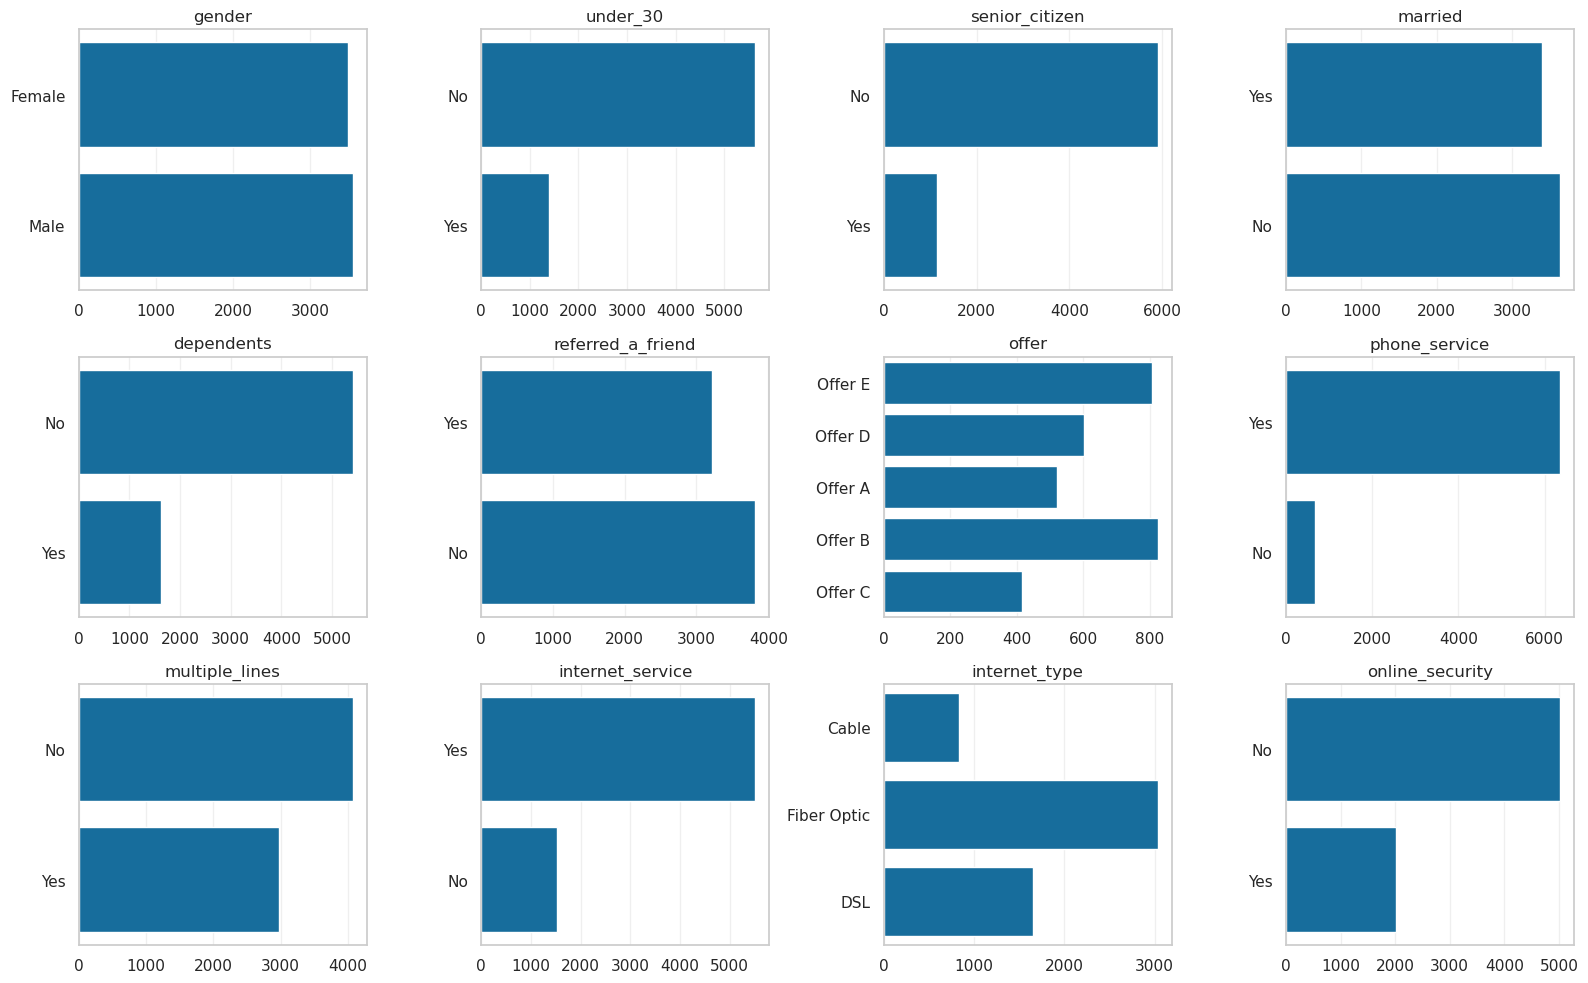

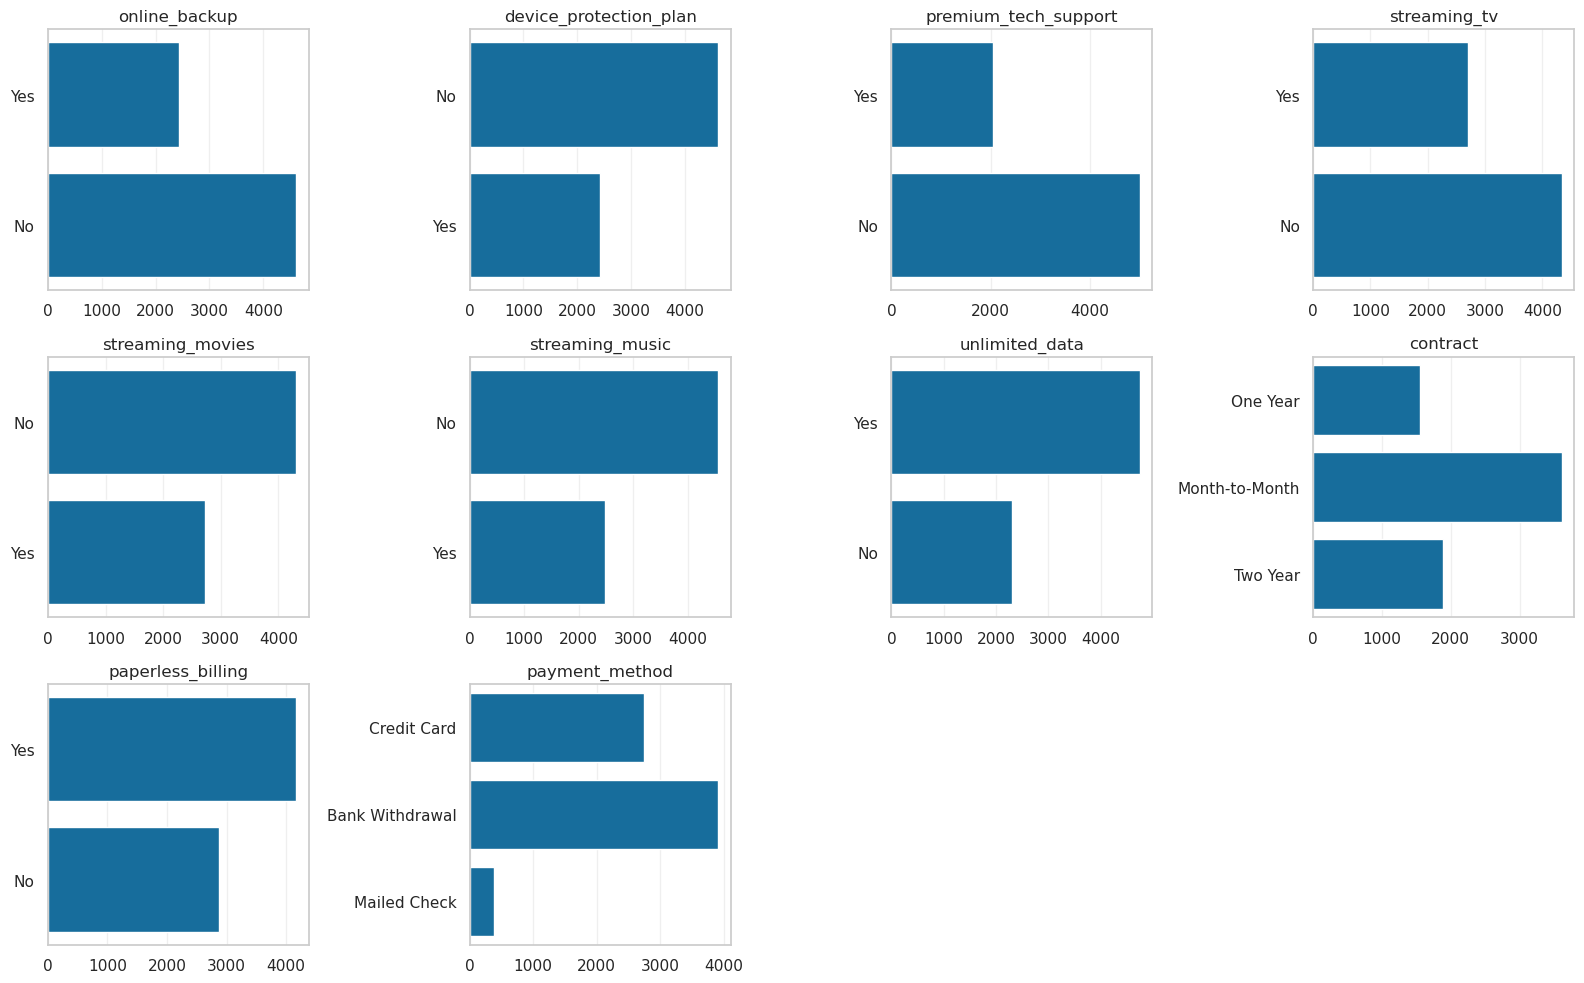

In [11]:
cat_cols = df.drop(['churn_label', 'customer_id', 'status_id', 'service_id'], axis=1).select_dtypes(['object']).columns

c = 0
for k in range(2):
    fig, ax = plt.subplots(3, 4, figsize=(16,10))
    for i in range(3):
        for j in range(4):
            if c >= len(cat_cols):
                ax[i][j].set_visible(False)
                continue
            sns.countplot(data=df, y=cat_cols[c], ax=ax[i][j])
            ax[i][j].set(title=cat_cols[c], xlabel='', ylabel='')
            c += 1
    plt.tight_layout()    
    plt.savefig(REPORTS_FIGURES / f'04_categorical_feat_distribution_{k}.png', dpi=150)
plt.show()

## 6. Bivariate Exploration

### 6.1. Numerical Features

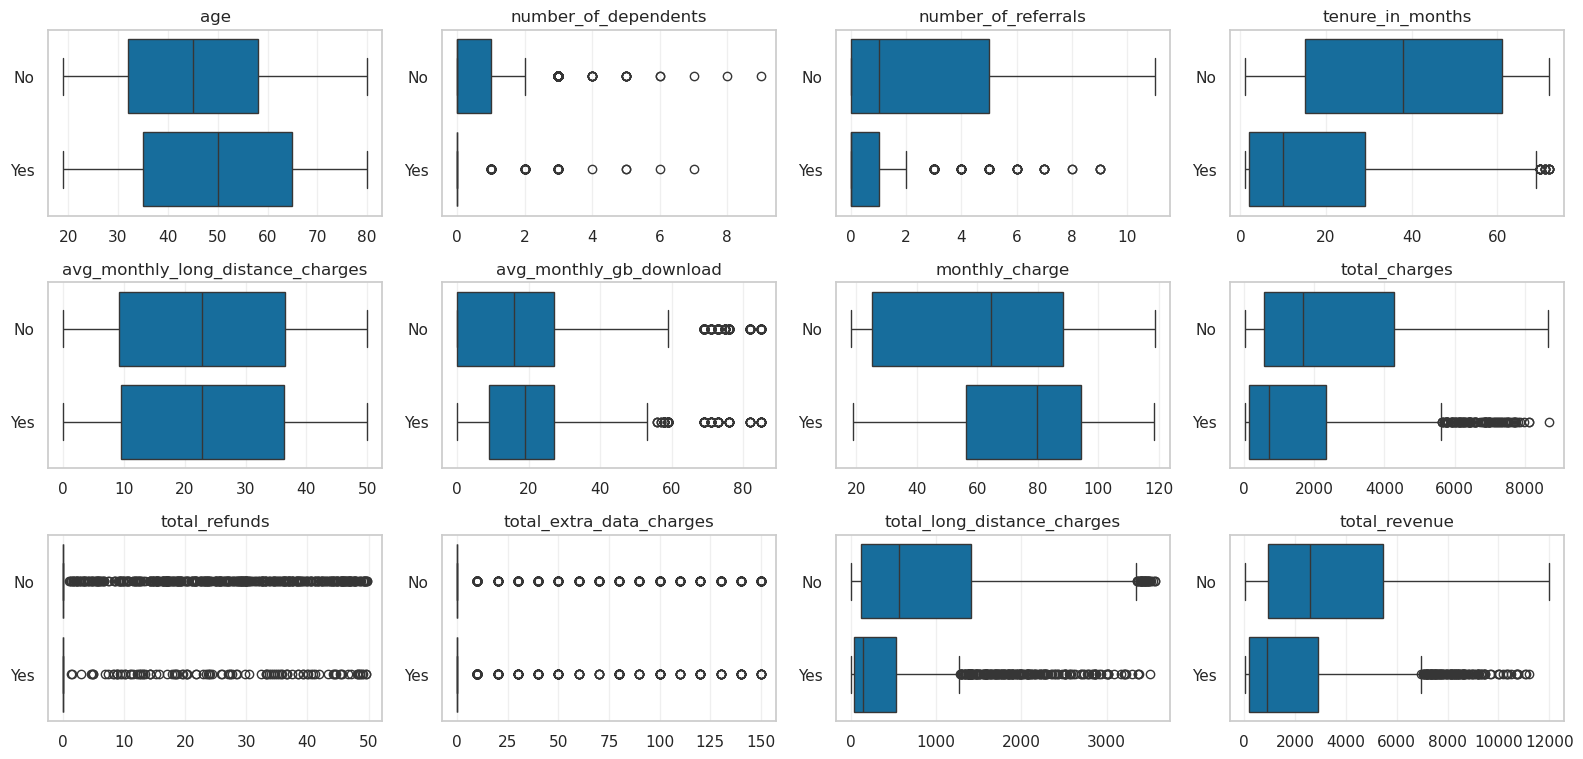

In [12]:
fig, ax = plt.subplots(4, 4, figsize=(16,10))
c = 0
for i in range(4):
    for j in range(4):
        if c >= len(num_cols):
            ax[i][j].set_visible(False)
            continue
        sns.boxplot(data=df, x=num_cols[c], y='churn_label', ax=ax[i][j])
        ax[i][j].set(title=num_cols[c], xlabel='', ylabel='')
        c += 1
    plt.tight_layout()
    
plt.savefig(REPORTS_FIGURES / '05_numeric_vs_target.png', dpi=150)
plt.show()

### 6.2. Categorical Features

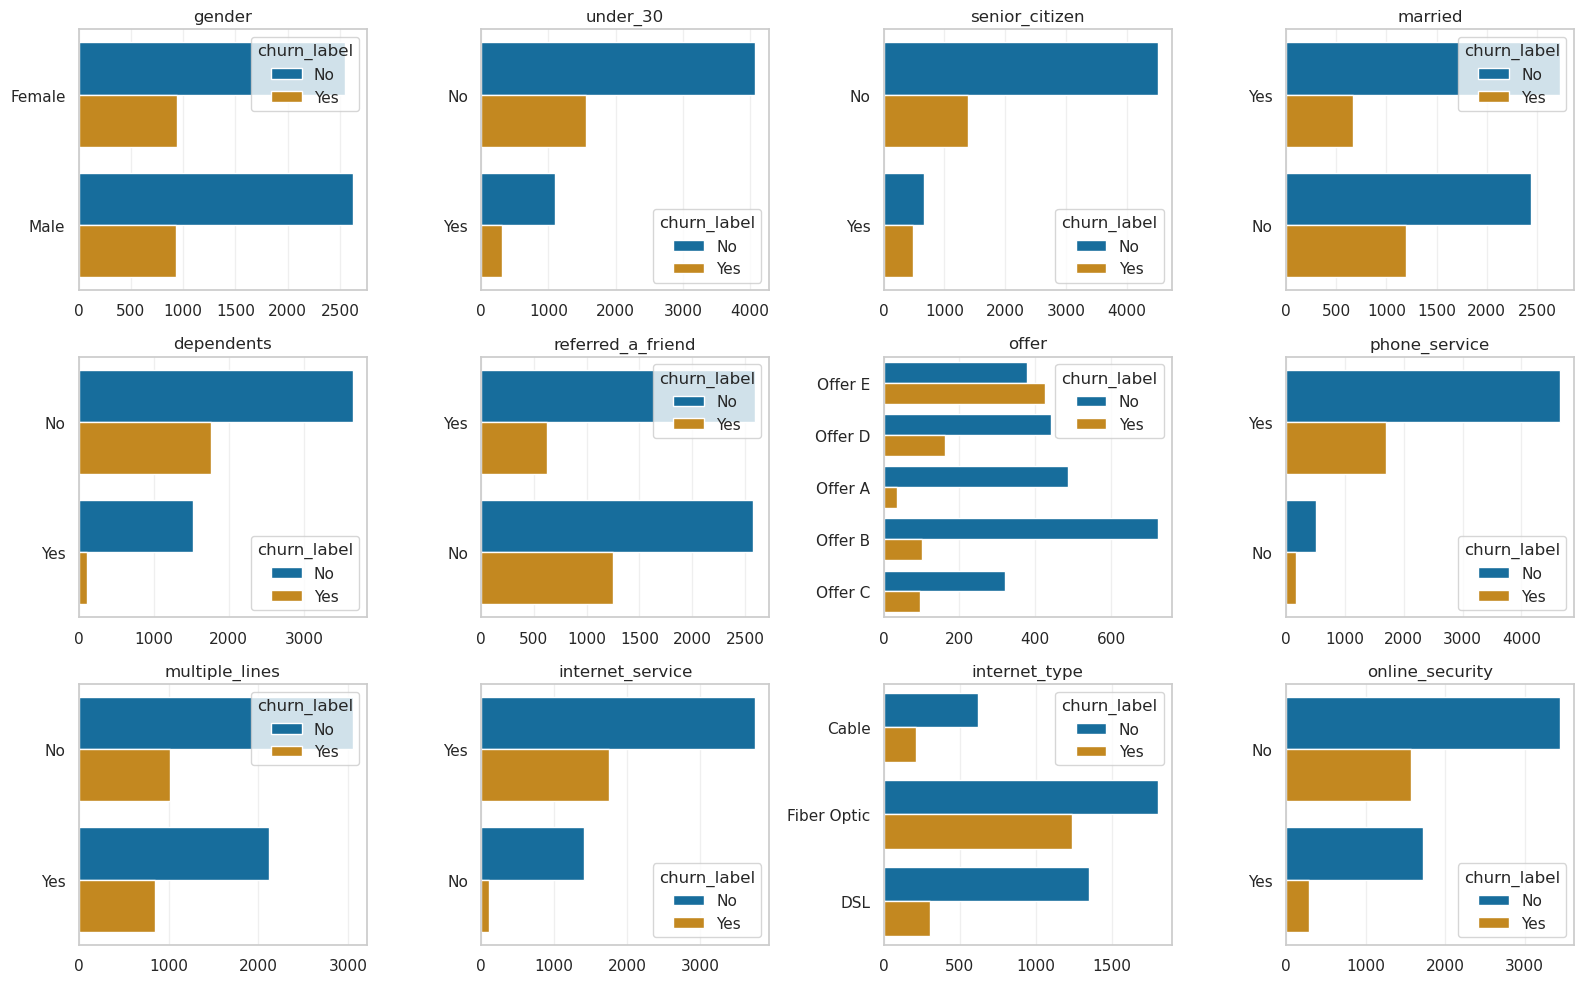

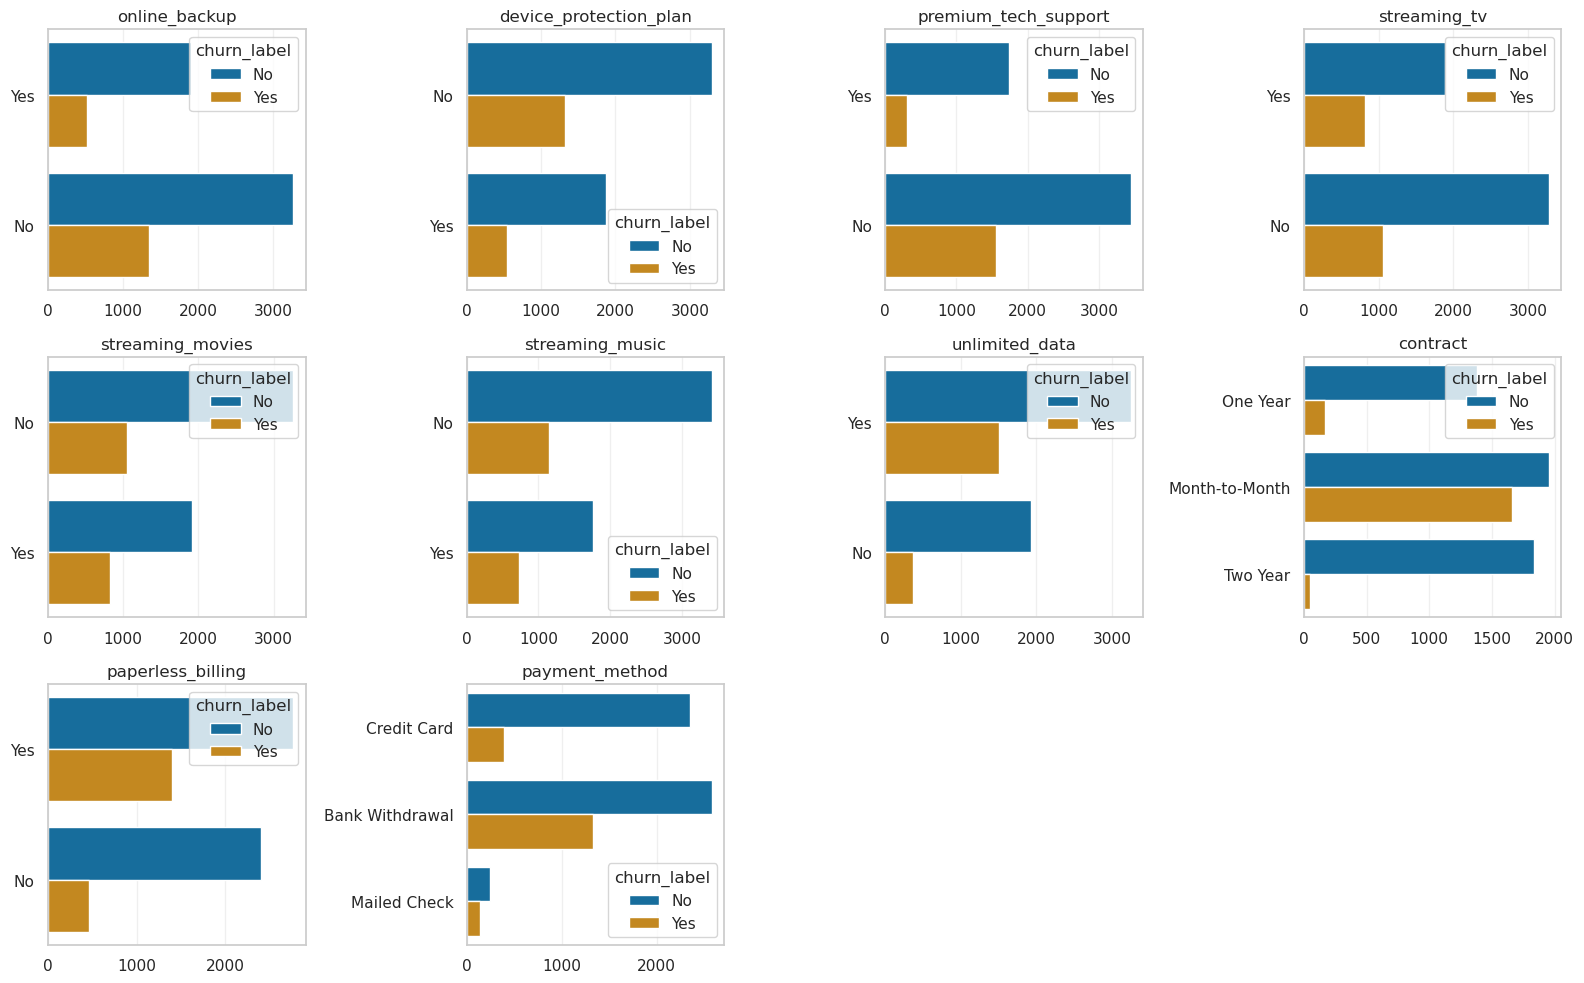

In [13]:
c = 0
for k in range(2):
    fig, ax = plt.subplots(3, 4, figsize=(16,10))
    for i in range(3):
        for j in range(4):
            if c >= len(cat_cols):
                ax[i][j].set_visible(False)
                continue
            sns.countplot(data=df, y=cat_cols[c], hue='churn_label', ax=ax[i][j])
            ax[i][j].set(title=cat_cols[c], xlabel='', ylabel='')
            c += 1
    plt.tight_layout()
    plt.savefig(REPORTS_FIGURES / f'06_categorical_vs_target_{k}.png', dpi=150)
plt.show()

## 7. Feature Engineering

In [14]:
# General feature engineering
df['avg_monthly_spending'] = df['total_charges'] / df['tenure_in_months']
df['revenue_minus_refunds'] = df['total_revenue'] - df['total_refunds']
df['age_group'] = pd.cut(df['age'], bins=[0,30,50,70,100], labels=['young','adult','senior','elder'])
df['contract_length_months'] = df['contract'].map({'Month-to-Month':1, 'One Year':12, 'Two Year':24})
df['has_streaming'] = df[['streaming_tv','streaming_movies','streaming_music']].eq('Yes').any(axis=1)

# Boolean features
df['is_under_30'] = (df['under_30'] == 'Yes').astype(int)
df['is_senior_citizen'] = (df['senior_citizen'] == 'Yes').astype(int)
df['is_married'] = (df['married'] == 'Yes').astype(int)
df['has_dependents'] = (df['dependents'] == 'Yes').astype(int)
df['has_referred_a_friend'] = (df['referred_a_friend'] == 'Yes').astype(int)
df['has_phone_service'] = (df['phone_service'] == 'Yes').astype(int)
df['has_multiple_lines'] = (df['multiple_lines'] == 'Yes').astype(int)
df['has_online_security'] = (df['online_security'] == 'Yes').astype(int)
df['has_online_backup'] = (df['online_backup'] == 'Yes').astype(int)
df['has_device_protection_plan'] = (df['device_protection_plan'] == 'Yes').astype(int)
df['has_premium_tech_support'] = (df['premium_tech_support'] == 'Yes').astype(int)
df['has_streaming_tv'] = (df['streaming_tv'] == 'Yes').astype(int)
df['has_streaming_movies'] = (df['streaming_movies'] == 'Yes').astype(int)
df['has_streaming_music'] = (df['streaming_music'] == 'Yes').astype(int)
df['has_unlimited_data'] = (df['unlimited_data'] == 'Yes').astype(int)
df['has_paperless_billing'] = (df['paperless_billing'] == 'Yes').astype(int)

# Total number of services feature:
binary_services = ['phone_service','internet_service','online_security','online_backup','device_protection_plan','premium_tech_support','streaming_tv','streaming_movies','streaming_music']
df['num_services'] = df[binary_services].eq('Yes').sum(axis=1)

## 8. Correlation Insights

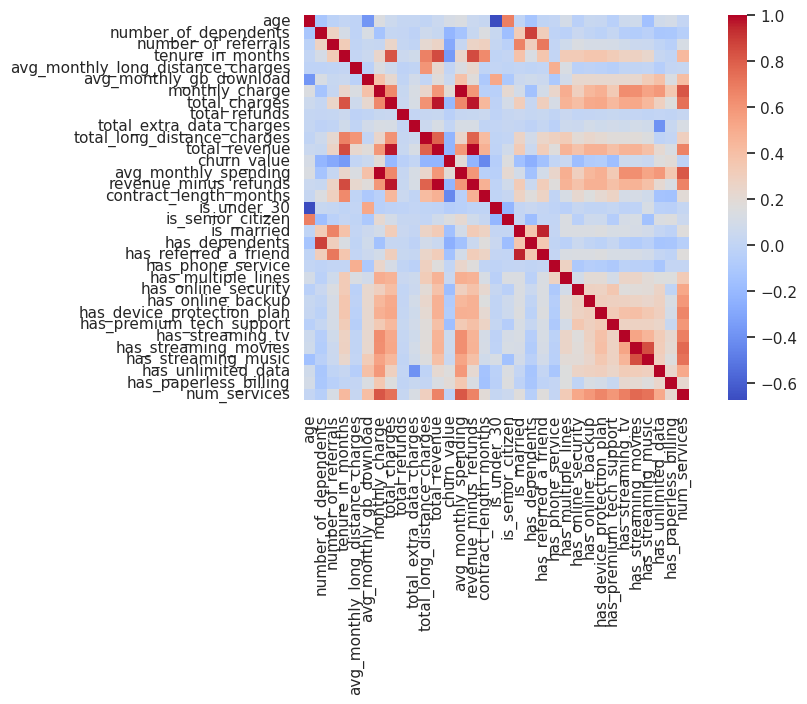

In [15]:
corr = df.select_dtypes(['number', 'float64', 'int64']).corr()
sns.heatmap(corr.fillna(0), cmap='coolwarm', square=True, xticklabels=True, yticklabels=True)
plt.savefig(REPORTS_FIGURES / f"07_correlation_map.png", dpi=150)
plt.show()

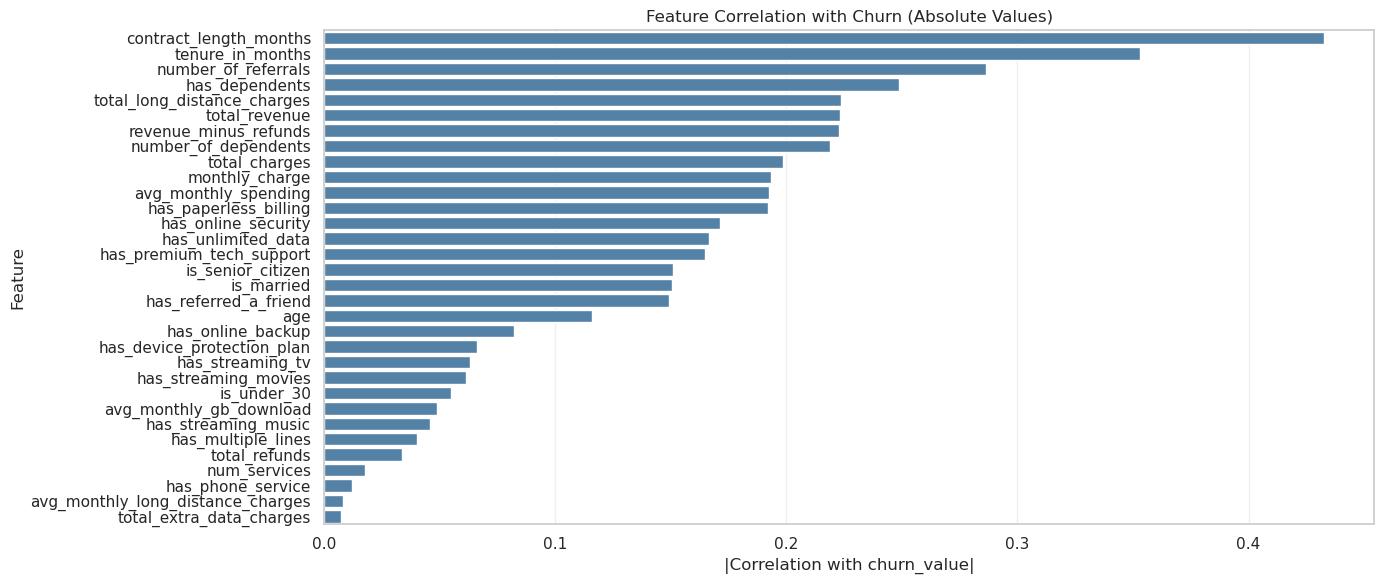

In [58]:
bar_corr = abs(corr.loc['churn_value']).sort_values(ascending=False)
plt.figure(figsize=(14, 6))
sns.barplot(x=bar_corr[1:].values, y=bar_corr[1:].index, orient='h', color='steelblue')
plt.xlabel('|Correlation with churn_value|')
plt.ylabel('Feature')
plt.title('Feature Correlation with Churn (Absolute Values)')
plt.tight_layout()
plt.savefig(REPORTS_FIGURES / f'08_correlation_plot.png', dpi=150)
plt.show()

## 9. Feature Selection for Modeling

**Columns to drop:**
- `customer_id`, `service_id`, `status_id`: unique codes, do not contribute to build the model
- `churn_label`: a boolean target already exists
- `under_30`, `senior_citizen`, `married`, `dependents`, `referred_a_friend`, `phone_service`, `multiple_lines`, `online_security`, `online_backup`, `device_protection_plan`, `premium_tech_support`, `streaming_tv`, `streaming_movies`, `streaming_music`, `unlimited_data`, `paperless_billing`: their boolean equivalents already exist
- `contract`: its ordinal encoded feature already exists
- `age_group`: might be redundant when age already exists

In [47]:
cols_to_drop = [
    'customer_id', 'service_id', 'status_id',
    'churn_label',
    
    'under_30', 'senior_citizen', 'is_under_30', 'is_senior_citizen', 'married', 'dependents', 'referred_a_friend', 'is_married', 'has_dependents', 'has_referred_a_friend', 'phone_service', 'multiple_lines',
    'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data', 'paperless_billing',
    
    'contract',
    'age_group',
    'avg_monthly_long_distance_charges'
]

df_finished = df.drop(cols_to_drop, axis=1)
df_finished.head(3)

,gender,age,number_of_dependents,number_of_referrals,tenure_in_months,...,has_streaming_movies,has_streaming_music,has_unlimited_data,has_paperless_billing,num_services
0,Female,37,0,2,9,...,0,0,1,1,5
1,Male,46,0,0,9,...,1,1,0,0,4
2,Male,50,0,0,4,...,0,0,1,1,3


In [48]:
# FEATURES SHORTLIST
cat_cols = [
    'gender', 'offer', 'internet_service', 'internet_type', 'payment_method'
]

num_cols = [
    'age', 'number_of_dependents', 'number_of_referrals', 'tenure_in_months',
    'contract_length_months', 'monthly_charge', 'total_charges', 'total_refunds',
    'total_extra_data_charges', 'total_long_distance_charges', 'total_revenue',
    'avg_monthly_gb_download', 'avg_monthly_spending', 'revenue_minus_refunds',
    'num_services'
]

binary_cols = [
    'has_phone_service', 'has_multiple_lines', 'has_online_security', 'has_online_backup',
    'has_device_protection_plan', 'has_premium_tech_support', 'has_streaming_tv',
    'has_streaming_movies', 'has_streaming_music', 'has_unlimited_data',
    'has_paperless_billing', 'has_streaming'
]

# ENGINEERED FEATURES
engineered = [
    'avg_monthly_spending', 'revenue_minus_refunds', 'contract_length_months',
    'num_services', 'has_streaming'
]

In [49]:
# --- SHORTLIST ---
features_df = pd.DataFrame({
    'Feature': [col for col in df_finished.columns if col != 'churn_value'],
    'Type': [df_finished[col].dtype for col in df_finished.columns if col != 'churn_value'],
    'Origin': ['engineered' if col in engineered else 'raw/encoded' for col in df_finished.columns if col != 'churn_value']
})

desc = {
    'gender': 'Customer gender',
    'age': 'Customer age',
    'number_of_dependents': 'Dependents count',
    'number_of_referrals': 'Referrals made',
    'tenure_in_months': 'Months with company',
    'contract_length_months': 'Contract length (mo)',
    'offer': 'Offer type',
    'internet_service': 'Internet service',
    'internet_type': 'Internet type',
    'payment_method': 'Payment method',
    'monthly_charge': 'Monthly charge',
    'total_charges': 'Total charges',
    'total_refunds': 'Refunds total',
    'total_extra_data_charges': 'Extra data fees',
    'total_long_distance_charges': 'Long distance fees',
    'total_revenue': 'Total revenue',
    'avg_monthly_gb_download': 'Avg GB download',
    'avg_monthly_spending': 'Avg monthly spend',
    'revenue_minus_refunds': 'Net revenue',
    'has_phone_service': 'Phone service (1/0)',
    'has_multiple_lines': 'Multiple lines (1/0)',
    'has_online_security': 'Online security (1/0)',
    'has_online_backup': 'Online backup (1/0)',
    'has_device_protection_plan': 'Device protection (1/0)',
    'has_premium_tech_support': 'Tech support (1/0)',
    'has_streaming_tv': 'TV streaming (1/0)',
    'has_streaming_movies': 'Movies streaming (1/0)',
    'has_streaming_music': 'Music streaming (1/0)',
    'has_unlimited_data': 'Unlimited data (1/0)',
    'has_paperless_billing': 'Paperless billing (1/0)',
    'num_services': 'Total services',
    'has_streaming': 'Any streaming (1/0)'
}

features_df['Description'] = features_df['Feature'].map(desc)
features_df

,Feature,Type,Origin,Description
0,gender,object,raw/encoded,Customer gender
1,age,int64,raw/encoded,Customer age
2,number_of_dependents,int64,raw/encoded,Dependents count
3,number_of_referrals,int64,raw/encoded,Referrals made
4,tenure_in_months,int64,raw/encoded,Months with company
5,offer,object,raw/encoded,Offer type
6,internet_service,object,raw/encoded,Internet service
7,internet_type,object,raw/encoded,Internet type
8,avg_monthly_gb_download,int64,raw/encoded,Avg GB download
9,payment_method,object,raw/encoded,Payment method


## 10. Export Artifacts

In [57]:
df_finished.to_csv(DATA_INTERIM / 'features_cleaned.csv', index=False)
features_df.to_csv(REPORTS_TABLES / 'feature_descriptions.csv', index=False)

print(f"Exported final cleaned dataset: ./{(DATA_INTERIM / 'features_cleaned.csv').as_posix()}")
print(f"Exported feature descriptions: ./{(REPORTS_TABLES / 'feature_descriptions.csv').as_posix()}")

Exported final cleaned dataset: ./../data/interim/features_cleaned.csv
Exported feature descriptions: ./../reports/tables/feature_descriptions.csv


## 12. Conclusions & Next Steps

**Conclusions**

* The dataset is now clean and consistent after removing ID, redundant, and leakage-prone features.
* Columns such as `churn_reason`, `churn_category`, and `customer_status` were dropped because they directly depend on the target, only churned customers contain values there.
* `churn_score`, `satisfaction_score`, and `cltv` were also removed to avoid data leakage, as they are derived metrics built from other internal variables.
* Correlation plots are not fully reliable in this dataset, since most relationships with the target are non-linear and the target is binary, moderate correlations (30–50%) may still explain much higher variance in churn behavior.
* In later stages, feature importance metrics such as `feature_importances_` (tree-based) and Permutation Importance will be used for more accurate variable comparison.
* The `offer` feature, despite containing around 4000 missing values, was kept for its importance, Figure `06_categorical_vs_target_1.png` shows that Offer E has the highest churn ratio, while A and B have the lowest. This feature can later be imputed with a constant `'No offer'` and encoded via One-Hot Encoding.
* The final feature set now includes well-defined numerical, binary, and engineered variables ready for modeling.

**Next Steps**

1. Impute missing values (e.g., `offer`) and encode categorical variables.
2. Split the dataset into training and validation sets.
3. Train baseline classifiers: Logistic Regression, KNN, SVM, Gradient Boosting, and Neural Network.
4. Compare performance metrics (Accuracy, Precision, Recall, F1, ROC-AUC).
5. Apply feature importance analysis (`feature_importances_`, Permutation Importance) to validate EDA findings.
6. Tune hyperparameters on the best models and re-evaluate.
7. A Python script in `../src/build_features.py` was implemented to automate the feature engineering steps consistently.
8. Document modeling results in a separate notebook within `/notebooks` for version control and reproducibility.
